In [1]:
import pandas as pd
import numpy as np
import os
os.chdir(r"/Users/kitchaichawmengchai/Downloads/VScode/Customer-Analytic/")


In [2]:
rfm= pd.read_csv('rfm.csv')
retail= pd.read_csv('data/retail_clean.csv')

In [3]:
rfm = rfm.dropna()

In [4]:
### splitting the columns
rfm['recency_groups']= rfm['rec_freq_monet'].astype('string').str.slice(0,1,1)
rfm['frequency_groups']= rfm['rec_freq_monet'].astype('string').str.slice(1,2,1)
rfm['monetary_groups']= rfm['rec_freq_monet'].astype('string').str.slice(2,3,1)


In [5]:
rfm.isna().sum()

Unnamed: 0          0
Customer ID         0
last_date           0
recency             0
rank_recency        0
frequency           0
freq_ranking        0
monetary            0
rank_monet          0
rec_freq_monet      0
recency_groups      0
frequency_groups    0
monetary_groups     0
dtype: int64

In [6]:
value_map= {'1':'3','3':'1','2':'2'}

In [7]:
rfm['recency_groups']= rfm['recency_groups'].map(value_map)
rfm['frequency_groups']= rfm['frequency_groups'].map(value_map)
rfm['monetary_groups']= rfm['monetary_groups'].map(value_map)

In [8]:
rfm = rfm.dropna()

In [12]:
# overall score
rfm['overall_score']= (rfm['recency_groups'].astype('int64')+rfm['frequency_groups'].astype('int64')+
                       rfm['monetary_groups'].astype('int64'))

In [10]:
### getting life time value
ltv= retail.groupby('Customer ID')['Revenue'].sum().reset_index()
ltv.columns=['Customer ID','ltv']

<Axes: ylabel='Frequency'>

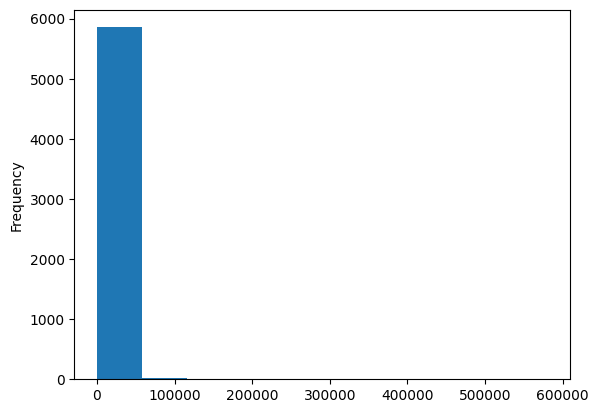

In [11]:
import matplotlib.pyplot as plt
ltv.ltv.plot(kind='hist')

<Axes: ylabel='ltv'>

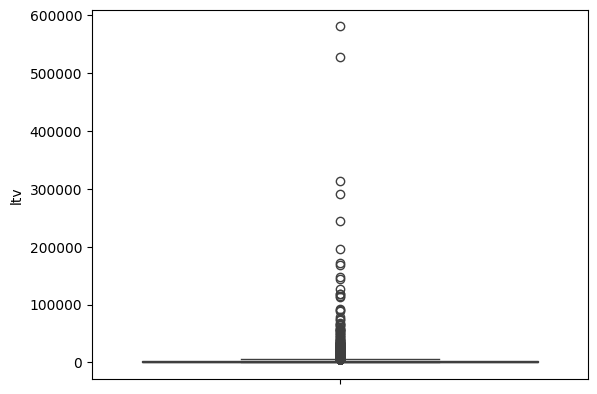

In [25]:
import seaborn as sns
sns.boxplot(y='ltv',data=ltv)

<Axes: ylabel='ltv'>

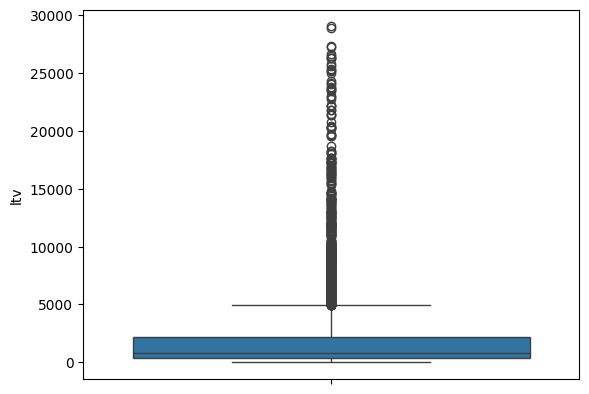

In [26]:
outliers_removed = ltv[ltv.ltv <= ltv.ltv.quantile(0.99)]
sns.boxplot(y= 'ltv',data = outliers_removed)


In [30]:
len(ltv)-len(outliers_removed)

59

In [31]:
from sklearn.cluster import KMeans
km= KMeans(n_clusters=3,n_init=10,max_iter=300)
fitting= km.fit_predict(outliers_removed[['ltv']])
outliers_removed['clusters']=fitting
outliers_removed.groupby('clusters')['ltv'].mean()

/var/folders/2h/rjm2fb_j53gb0nswwgx_xyfc0000gn/T/ipykernel_9304/274744200.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  outliers_removed['clusters']=fitting


clusters
0      909.50795
1    16389.79848
2     5696.24859
Name: ltv, dtype: float64

In [32]:
outliers_removed['clusters']=outliers_removed['clusters'].astype('string')
ltv_mapping= {'0':'Low_ltv','1': 'Mid_ltv','2':'High_ltv'}
outliers_removed['clusters']=outliers_removed['clusters'].map(ltv_mapping)

/var/folders/2h/rjm2fb_j53gb0nswwgx_xyfc0000gn/T/ipykernel_9304/4151229766.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  outliers_removed['clusters']=outliers_removed['clusters'].astype('string')
/var/folders/2h/rjm2fb_j53gb0nswwgx_xyfc0000gn/T/ipykernel_9304/4151229766.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  outliers_removed['clusters']=outliers_removed['clusters'].map(ltv_mapping)


In [33]:
rfm.columns
rfm_data= rfm.loc[:,['Customer ID','recency','frequency','monetary','recency_groups',
                     'frequency_groups', 'monetary_groups','overall_score']]

In [34]:
joined_data= pd.merge(outliers_removed[['Customer ID','clusters']],rfm_data,
                      how='left',on= 'Customer ID')

In [36]:
joined_data.drop('Customer ID',axis=1,inplace=True)
X_1= pd.get_dummies(joined_data.drop('clusters',axis=1))
columns=X_1.columns
X=X_1.values
y= joined_data['clusters'].values


In [38]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV

In [41]:
model_tree= DecisionTreeClassifier()
cv= RepeatedStratifiedKFold(n_splits=3,n_repeats=3,random_state=1)
scores= cross_val_score(model_tree,X,y,scoring='accuracy',cv=cv)
scores.mean()

0.8692319767623707

In [43]:
param_dist = {"max_depth": [3, None],
           "min_samples_leaf": range(1,9),
             "criterion": ["gini", "entropy"]}

In [44]:
tree= DecisionTreeClassifier()
rf= RandomForestClassifier()

In [45]:
tree_cv= RandomizedSearchCV(tree,param_dist,cv=5)
rf_cv= RandomizedSearchCV(rf, param_dist,cv=5)

In [46]:
tree_cv.fit(X,y)

RandomizedSearchCV(cv=5, estimator=DecisionTreeClassifier(),
                   param_distributions={'criterion': ['gini', 'entropy'],
                                        'max_depth': [3, None],
                                        'min_samples_leaf': range(1, 9)})

In [47]:
rf_cv.fit(X,y)

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(),
                   param_distributions={'criterion': ['gini', 'entropy'],
                                        'max_depth': [3, None],
                                        'min_samples_leaf': range(1, 9)})

In [48]:
tree_cv.best_score_

0.8832026606492338

In [49]:
rf_cv.best_score_

0.8916176275386045

In [50]:
prediction=rf_cv.predict(X)

In [51]:
comparison_data= pd.DataFrame({'Actual': y,'Prediction':prediction})

In [53]:
comparison_data.groupby(['Actual','Prediction'])[['Actual','Prediction']].count()

Actual  Prediction
Actual   Prediction                    
High_ltv High_ltv       439         439
         Low_ltv        338         338
         Mid_ltv         14          14
Low_ltv  High_ltv        81          81
         Low_ltv       4772        4772
         Mid_ltv          1           1
Mid_ltv  High_ltv        71          71
         Low_ltv         40          40
         Mid_ltv         66          66